# Prepare time series data for causal impact evaluation

This notebook shows how to prepare a daily time series dataset for **causal impact / synthetic control style** evaluation:

- input schema and required columns
- missing dates handling
- feature engineering (time trend, day-of-week)
- saving a prepared dataset for downstream notebooks

In [18]:
import sys
from pathlib import Path

repo_root = Path.cwd()
src_path = repo_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tecore.causal import DataSpec
from tecore.causal.schema import validate_timeseries_df
from tecore.causal.preprocess import prepare_timeseries

## 1) Load a dataset

You can use:
- `data/example_ts/example_daily.csv` (bundled example)
- or your own CSV (must include `date` and `y` + optional covariates)

In [12]:
data_path = repo_root / "data" / "example_ts" / "example_daily.csv"
df_raw = pd.read_csv(data_path)
df_raw.head()

,date,y,sessions,active_users,marketing_spend,external_index
0,2025-01-01,97.616245,988.943379,198.716154,316.958312,50.248343
1,2025-01-02,105.742902,999.467235,201.510842,345.711472,49.179587
2,2025-01-03,105.167795,1012.098816,190.633450,330.625805,47.522091
3,2025-01-04,100.247906,966.607797,196.239342,280.999858,51.124048
4,2025-01-05,90.416795,977.884766,196.079431,306.072805,43.074491


## 2) Define the input spec

For v1 we focus on a single treated unit:

- `date`: daily index (YYYY-MM-DD)
- `y`: target KPI (revenue/orders/margin/…)
- `x_cols`: covariates (controls)

Recommended covariates:
- sessions / DAU / marketing spend / external index

In [13]:
spec = DataSpec(
    date_col="date",
    y_col="y",
    x_cols=["sessions", "active_users", "marketing_spend", "external_index"],
    freq="D",
    missing_policy="raise",
    aggregation="mean",
    add_time_trend=True,
    add_day_of_week=True,
    winsorize_p=None,
)

df_valid = validate_timeseries_df(df_raw, spec)
df_valid.dtypes

date datetime64[ns]
y float64
sessions float64
active_users float64
marketing_spend float64
external_index float64
dtype: object

## 3) Sanity plots

Quick plots for `y` and covariates.

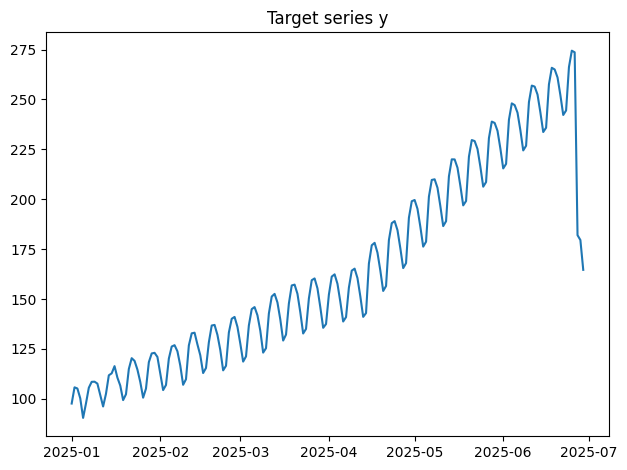

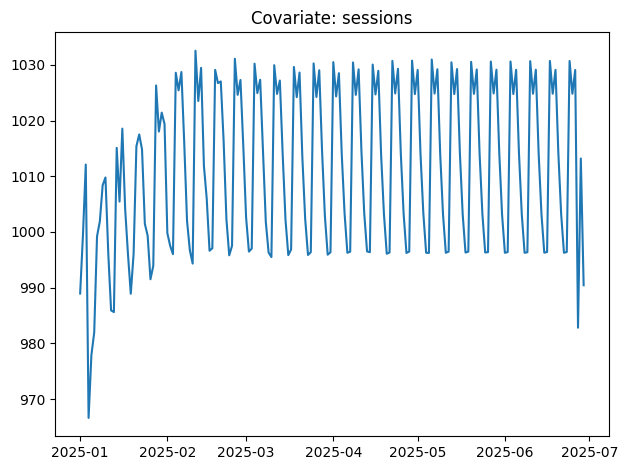

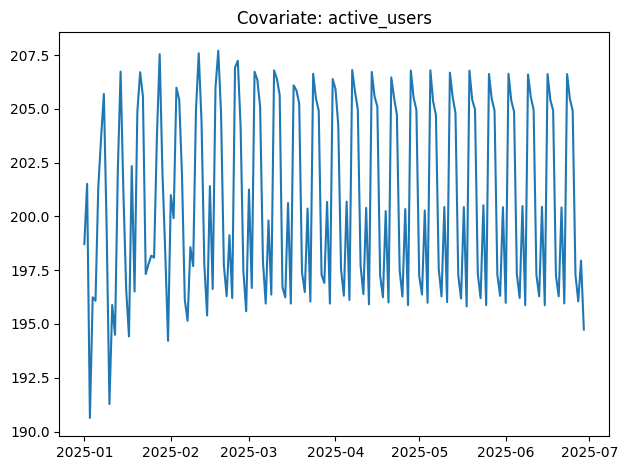

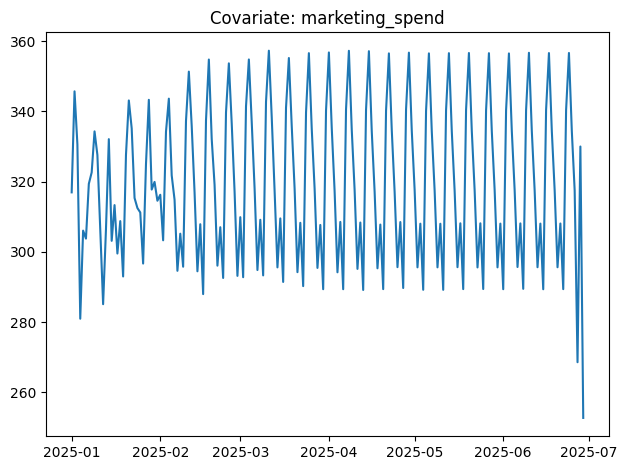

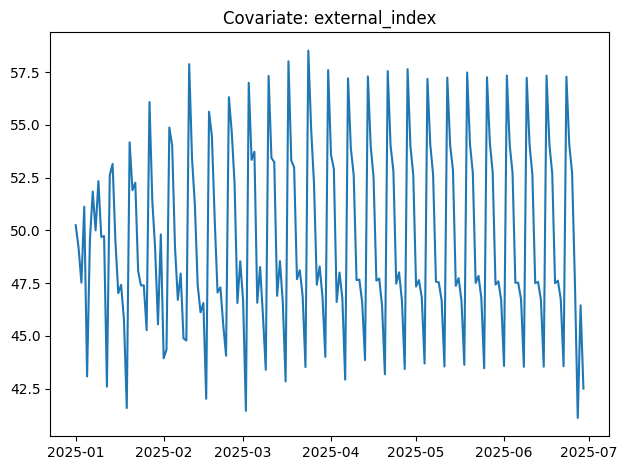

In [14]:
df_plot = df_valid.copy()
df_plot[spec.date_col] = pd.to_datetime(df_plot[spec.date_col])

plt.figure()
plt.plot(df_plot[spec.date_col], df_plot[spec.y_col])
plt.title("Target series y")
plt.tight_layout()
plt.show()

for c in spec.x_cols:
    plt.figure()
    plt.plot(df_plot[spec.date_col], df_plot[c])
    plt.title(f"Covariate: {c}")
    plt.tight_layout()
    plt.show()

## 4) Prepare data for the causal module

Preparation does:
- align to a complete calendar (daily)
- apply missing-date policy
- add features: `_t` (time trend) and `dow_*` (day-of-week dummies)
- split into pre/post using an intervention date

In [15]:
intervention_date = pd.Timestamp("2025-05-01")

prepared = prepare_timeseries(df_valid, spec, intervention_date=intervention_date)
prepared.df.head()

,date,y,sessions,active_users,marketing_spend,external_index,_t,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,2025-01-01,97.616245,988.943379,198.716154,316.958312,50.248343,0.0,False,True,False,False,False,False
1,2025-01-02,105.742902,999.467235,201.510842,345.711472,49.179587,1.0,False,False,True,False,False,False
2,2025-01-03,105.167795,1012.098816,190.633450,330.625805,47.522091,2.0,False,False,False,True,False,False
3,2025-01-04,100.247906,966.607797,196.239342,280.999858,51.124048,3.0,False,False,False,False,True,False
4,2025-01-05,90.416795,977.884766,196.079431,306.072805,43.074491,4.0,False,False,False,False,False,True


### Prepared dataset summary

In [16]:
print("n_total:", len(prepared.df))
print("n_pre:", int(prepared.pre_mask.sum()))
print("n_post:", int(prepared.post_mask.sum()))
print("features:", len(prepared.feature_cols))
prepared.feature_cols[:20]

n_total: 180
n_pre: 120
n_post: 60
features: 11


['sessions',
 'active_users',
 'marketing_spend',
 'external_index',
 '_t',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6']

## 5) Save prepared dataset

We save the prepared dataset for the next notebooks.

Note: the causal module will re-run preprocessing internally; this export is mainly for transparency and demos.

In [17]:
out_dir = repo_root / "data" / "prepared_ts"
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "prepared_example_daily.csv"
prepared.df.to_csv(out_path, index=False)

print("Wrote:", out_path)

Wrote: /data/workspace_files/trustworthy-experiments-core-main/data/prepared_ts/prepared_example_daily.csv


## Results summary

- We converted the raw input into a causal-ready daily time series with a single outcome `y`, a clean `date` index, and a set of covariates `x_*` suitable for counterfactual modeling.
- We applied basic data quality checks that are critical for causal time-series analysis:
  - continuous date coverage (no missing days) or a clearly defined missing-date policy,
  - consistent types and sorted timestamps,
  - quick sanity plots for `y` and covariates to detect obvious breaks, outliers, or data pipeline issues.
- We engineered minimal seasonality controls (day-of-week features and an optional time trend) to improve pre-period fit stability.
- The prepared dataset is saved and can be used directly in the next notebook (09) for impact estimation, uncertainty, and trustworthiness diagnostics (pre-fit quality gates and placebo-in-time).

### What to verify before moving on

- The pre-intervention window is long enough (rule of thumb: at least 4–8 weeks of stable pre data).
- Key covariates are plausibly unaffected by the intervention and have reasonable correlation with `y` in the pre period.
- There are no obvious structural breaks in covariates at the intervention date (a common source of biased counterfactuals).